# Amazon products reviews analysis 


Objectives:

- Analyze the Electonics products, such as IPad & Tablets to get a better understanding
- Develop a sentiment model to predict the optics of the reviews 

In [481]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

import itertools
from collections import Counter

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [441]:
# texting cleaning function

def cleanText(text):
    stop_words = set(stopwords.words('english')) 
    punct = set(string.punctuation)
    
    text = text.lower()
    text = ''.join(word for word in text if word not in punct) #remove punctuation
    text = re.sub('\n','',text)
    text = word_tokenize(text) # tonkenize words
    text = [i for i in text if not i in stop_words] #remove stop words
    
    return text

In [698]:
# extracting categories fucntion

def getCat(text):
    if len(text) >=2:
        main_cat = text[0]
        sub_cat_1 = text[1]
    else:
        main_cat = text[0]
        sub_cat_1 = np.NaN
    return main_cat, sub_cat_1  

In [656]:
df = pd.read_csv('Amazon products reviews.csv')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [657]:
df.shape

(34660, 21)

In [658]:
# Renaming columns
df.columns = ['id', 'name', 'asins', 
              'brand', 'categories', 'keys', 
              'manufacturer','date', 'dateAdded', 
              'dateSeen','didPurchase', 'doRecommend',
              'review id','numHelpful', 'rating', 
              'sourceURLs','text', 'title',
              'userCity','userProvince', 'username']

In [659]:
# checking missing values
df.isnull().sum()

id                  0
name             6760
asins               2
brand               0
categories          0
keys                0
manufacturer        0
date               39
dateAdded       10621
dateSeen            0
didPurchase     34659
doRecommend       594
review id       34659
numHelpful        529
rating             33
sourceURLs          0
text                1
title               5
userCity        34660
userProvince    34660
username            2
dtype: int64

In [660]:
df.drop(labels=['id','asins','keys','dateSeen','sourceURLs','review id','didPurchase','userCity','userProvince'],axis=1,inplace=True)

df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
df['dateAdded'] = df['dateAdded'].apply(lambda x: pd.to_datetime(x))

In [661]:
df.head()

,name,brand,categories,manufacturer,date,dateAdded,doRecommend,numHelpful,rating,text,title,username
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017-01-13,2017-07-03 23:33:15,True,0.0,5.0,This product so far has not disappointed. My c...,Kindle,Adapter
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017-01-13,2017-07-03 23:33:15,True,0.0,5.0,great for beginner or experienced person. Boug...,very fast,truman
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017-01-13,2017-07-03 23:33:15,True,0.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017-01-13,2017-07-03 23:33:15,True,0.0,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017-01-12,2017-07-03 23:33:15,True,0.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42


### Exploratory analysis

#### user 

In [668]:
user = df.username.value_counts()

In [681]:
print('total review = ' + str(user.sum())) 
print('total user = '+ str(user.count()))
print('review per user = ' +str(user.sum()/user.count()))
print('number of users who submits more than 20 reviews is '+ str(user[user>20].count()))

total review = 34658
total user = 26789
review per user = 1.2937399678972712
number of users who submits more than 20 reviews is 50


In [684]:
username_rating = df[['rating','username']]

frequent_reviewer = user[user>20]

username_rating['frequent reviewer'] = username_rating['username'].apply(lambda x: 1 if x in frequent_reviewer.index else 0)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


C:\Anaconda\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5,1,'rating distribution of non-frequent reviewers')

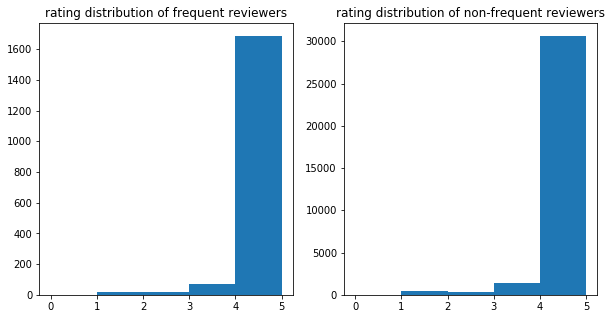

In [697]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.hist(username_rating[username_rating['frequent reviewer']==1]['rating'],bins=5, range = (0,5))
plt.title('rating distribution of frequent reviewers')
plt.subplot(122)
plt.hist(username_rating[username_rating['frequent reviewer']==0]['rating'],bins=5, range = (0,5))
plt.title('rating distribution of non-frequent reviewers')

Conclusion: frequent reviewers do not seem to give a bias rating becuase they have the same distribution as non-frequent reviewers

#### Categories 

In [13]:
#print('There are', df['categories'].nunique(), 'unique values in category name column')

In [246]:
# Splitting the categories to find some keywords

df['categories']=df['categories'].apply(lambda x: x.split(','))

packed_cat_list = []

for i in range(len(df['categories'])):
    packed_cat_list.append(df['categories'][i])
cat_list =list(itertools.chain(*packed_cat_list))

tfidf_vectorizer=TfidfVectorizer(use_idf=True, ngram_range=(1,1),tokenizer=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(cat_list)
feature_array = np.array(tfidf_vectorizer.get_feature_names())
#tfidf_sorting = np.argsort(tfidf_vectorizer_vectors.toarray())
feature_array 

array(['2nd', '3g', '4gb', '4th', '5th', 'accessories', 'accs',
       'adapters', 'alarms', 'all', 'amazon', 'android', 'assistant',
       'assistants', 'audio', 'automation', 'back', 'bags', 'batteries',
       'beauty', 'bluetooth', 'book', 'books', 'brands', 'business',
       'cables', 'cases', 'categories', 'cell', 'chargers', 'clearance',
       'co', 'college', 'components', 'computer', 'computers',
       'connected', 'consumer', 'controllers', 'controls', 'covers',
       'deals', 'device', 'devices', 'dining', 'dishes', 'docks',
       'drives', 'dx', 'ebook', 'echo', 'electrical', 'electronic',
       'electronics', 'enabled', 'entertainment', 'ereaders', 'family',
       'featured', 'features', 'fi', 'fire', 'for', 'frys', 'furniture',
       'games', 'garage', 'generation', 'global', 'hard', 'headphones',
       'holiday', 'home', 'hubs', 'improvement', 'internet', 'ipad',
       'ipads', 'ipod', 'kids', 'kindle', 'kitchen', 'laptops', 'living',
       'lotions', 'magazi

In [297]:
# Splitting the cateogroy into 2 categories

df['main_cat'], df['sub_cat_1'] = zip(*df['categories'].apply(lambda x: getCat(x)))  

In [303]:
Cat_group = df.groupby(['main_cat','sub_cat_1'])

In [321]:
Cat_group.agg({'rating':['mean','count']})

rating       
                                                                mean  count
main_cat                       sub_cat_1                                   
Amazon Device Accessories      Kindle Store                 3.666667      6
Amazon Devices & Accessories   Amazon Device Accessories    4.440299    402
Back To College                College Electronics          4.707278   5056
Cases                          Kindle Store                 3.923077     13
Categories                     Streaming Media Players      3.125000      8
Chargers & Adapters            Computers & Accessories      4.205479     73
Computers & Tablets            E-Readers & Accessories      4.862745     51
                               Tablets                      4.700000     10
Computers/Tablets & Networking Tablet & eBook Reader Accs   2.461538     13
                               Tablets & eBook Readers      4.504817   1038
Electronics                    Amazon Device Accessories    3.500000     10
                               Categories                   5.000000      4
                               Computers                    4.833333      6
                               Tablets & E-Readers          4.558594    256
                               eBook Readers & Accessories  3.300000     20
                               iPad & Tablets               4.583115   3056
Electronics Features           Fire Tablets                 4.424731    372
Featured Brands                Electronics                  4.531447    636
Fire Tablets                   Tablets                      4.457044  11244
Frys                           Software & Books             4.500000      2
Kindle E-readers               Electronics Features         4.666667      6
Kindle Store                   Amazon Devices                    NaN      0
                               Categories                   4.500000     16
Power Adapters & Cables        Electronics                  4.875000      8
Rice Dishes                    Ready Meals                       NaN      0
Stereos                        Remote Controls              4.671098   6619
TVs Entertainment              Wireless Speakers            4.285714      7
Tablets                        Fire Tablets                 4.532041   1857
Walmart for Business           Office Electronics           4.765708   3756
eBook Readers                  Kindle E-readers             4.611940     67
mazon.co.uk                    Amazon Devices               4.666667     15

#### name

In [223]:
name = df[df['name'].notnull()]['name']

name = name.apply(lambda x: x.split(','))

In [225]:
packed_name_list = []

for i in range(len(name)):
    packed_name_list.append(name[i])
name_list =list(itertools.chain(*packed_name_list))

In [244]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, ngram_range=(1,1))
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(name_list)

feature_array = np.array(tfidf_vectorizer.get_feature_names())
#tfidf_sorting = np.argsort(tfidf_vectorizer_vectors.toarray())
feature_array 

array(['10', '12', '16', '16gb', '1st', '2011', '2014', '2015', '2016',
       '2nd', '300', '32', '3g', '3rd', '4gb', '4th', '5ft', '5th', '5w',
       '6th', '8gb', '8in', '9w', 'adapter', 'adaptive', 'alexa', 'all',
       'aluminum', 'amazon', 'and', 'android', 'angle', 'b018szt3bk',
       'black', 'blue', 'bluetooth', 'brand', 'built', 'cable', 'case',
       'cayenne', 'certified', 'charger', 'charging', 'coconut', 'cover',
       'display', 'dx', 'dxs', 'ebook', 'echo', 'edition', 'ereaders',
       'fi', 'fire', 'fits', 'for', 'free', 'gb', 'gen', 'generation',
       'glare', 'green', 'hd', 'high', 'in', 'includes', 'ips',
       'keyboard', 'kid', 'kids', 'kindle', 'latest', 'leather', 'light',
       'lighted', 'magenta', 'merlot', 'micro', 'monochrome', 'most',
       'new', 'oasis', 'oem', 'of', 'offers', 'official', 'olive', 'oz',
       'pack', 'pagepress', 'paperwhite', 'portable', 'power',
       'powerfast', 'ppi', 'previous', 'proof', 'protective', 'reader',
       

#### Brand

In [256]:
Brand = df.groupby('brand')

In [260]:
Brand['doRecommend'].sum()

brand
Amazon                          26949
Amazon Coco T                       0
Amazon Digital Services Inc.        0
Amazon Echo                       589
Amazon Fire                       241
Amazon Fire Tv                   4903
Name: doRecommend, dtype: int64

In [262]:
Brand['rating'].mean()

brand
Amazon                          4.564721
Amazon Coco T                        NaN
Amazon Digital Services Inc.    3.500000
Amazon Echo                     4.531447
Amazon Fire                     4.558594
Amazon Fire Tv                  4.707278
Name: rating, dtype: float64

### Sentiment analysis on IPad & Tablets

In [451]:
df_sub1 = df[df['sub_cat_1']=='Tablets']
df_sub1.reset_index(inplace=True,drop = True)
df_sub2 = df[df['sub_cat_1']=='iPad & Tablets']
df_sub2.reset_index(inplace=True, drop = True)

df_sub = pd.concat([df_sub1,df_sub2])

columns=['name','brand', 'categories','main_cat','sub_cat_1',
         'manufacturer','date', 'dateAdded','doRecommend',
         'numHelpful', 'rating','text', 'title','username']
df_sub = df_sub[columns]

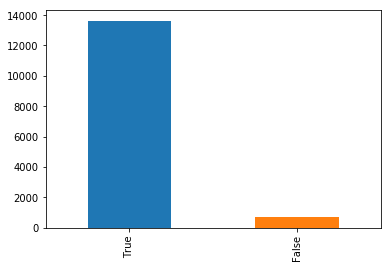

In [440]:
df_sub['doRecommend'].value_counts().plot.bar()

In [452]:
df_sub['text'] = df_sub['text'].apply(lambda x: cleanText(x))

df_sub = df_sub[['text','doRecommend']]

In [472]:
df_sub['text'] = df_sub['text'].apply(lambda x: ' '.join(x))
df_sub['doRecommend'] = df_sub['doRecommend'].replace(['True','False'],['1','0'])
df_sub.dropna(axis=0,inplace = True)
X = df_sub['text']
y = df_sub['doRecommend']

In [476]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

In [518]:
RUS = RandomUnderSampler()
X_train_rus, y_train_rus = RUS.fit_resample(X_train.values.reshape(-1, 1),y_train.values)

X_train_rus = X_train_rus.tolist()

X_train_rus =list(itertools.chain(*X_train_rus))

In [527]:
vectorizer = TfidfVectorizer()
LR = LogisticRegression()

def sentiment_prediction(X_train,y_train,X_test,y_test,vectorizer=vectorizer, ngram = (1,3), classifier=LR):
    vectorizer.set_params(ngram_range = ngram,max_features=10000)
    X_train_Tfidf = vectorizer.fit_transform(X_train)
    X_test_Tfidf = vectorizer.transform(X_test)
    
    LR.fit(X_train_Tfidf, y_train)
    
    y_pred = LR.predict(X_test_Tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [530]:
predAccuracy = sentiment_prediction(X_train,y_train,X_test,y_test)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [531]:
predAccuracy

0.9542278127183788

### Sentiment prediction for Electronics products 

In [595]:
df_elect = df[df['main_cat']=='Electronics']

In [596]:
df_elect.isnull().sum()

name            281
brand             0
categories        0
manufacturer      0
date              8
dateAdded       507
doRecommend      40
numHelpful       19
rating            5
text              0
title             1
username          0
main_cat          0
sub_cat_1         0
dtype: int64

In [602]:
df_elect= df_elect.dropna(subset = ['rating'],axis=0)

(array([   0.,   41.,   33.,  125., 3153.]),
 array([0., 1., 2., 3., 4., 5.]),
 <a list of 5 Patch objects>)

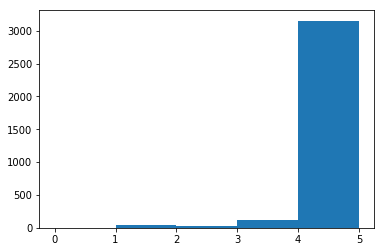

In [605]:
plt.figure()
plt.hist(df_elect['rating'],bins=5,range=(0,5))

In [606]:
df_elect['sentiment'] = df_elect['rating']>4
df_elect['sentiment'] = df_elect['sentiment'].replace([True , False] , ['pos' , 'neg'])

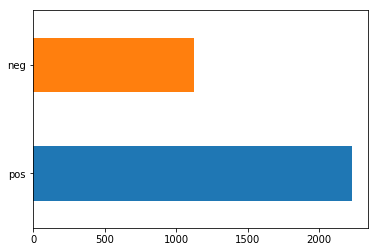

In [607]:
df_elect['sentiment'].value_counts().plot(kind='barh')

In [608]:
df_elect['text'] = df_elect['text'].apply(lambda x: cleanText(x))
df_elect['text'] = df_elect['text'].apply(lambda x: ' '.join(x))

In [609]:
X = df_elect['text']
y = df_elect['sentiment']

In [611]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

In [644]:
vectorizer = TfidfVectorizer()
LR = LogisticRegression()


vectorizer.set_params(ngram_range = (1,3),max_features=100)
X_train_Tfidf = vectorizer.fit_transform(X_train)
X_test_Tfidf = vectorizer.transform(X_test)

LR.fit(X_train_Tfidf, y_train)
    
y_pred = LR.predict(X_test_Tfidf)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [645]:
Results = pd.DataFrame(data = list(zip(vectorizer.get_feature_names(),LR.coef_[0])), columns = ['words','score'])
Results.sort_values(by='score',ascending = False)


,words,score
57,love,1.748070
67,perfect,1.661569
20,daughter,1.603422
58,loves,1.247838
78,recommend,1.156180
7,battery life,1.023668
70,prime,0.975310
75,read,0.970919
61,much,0.965738
8,best,0.917308


In [641]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         neg       0.66      0.18      0.28       225
         pos       0.70      0.95      0.80       446

    accuracy                           0.69       671
   macro avg       0.68      0.57      0.54       671
weighted avg       0.68      0.69      0.63       671



<Figure size 1152x576 with 0 Axes>

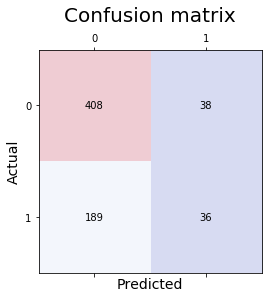

In [649]:
confusionMatrix = confusion_matrix(y_test,y_pred,labels=['pos','neg'])

plt.figure(figsize=(16, 8))
plt.matshow(confusionMatrix, cmap=plt.cm.coolwarm, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=confusionMatrix[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

##### testing model with artificial reviews

In [654]:
def test_sample(model, sample):
    sample_tfidf = vectorizer.transform([sample])
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("the review is estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

In [655]:
test_sample(LR, "The product was good and easy to use")
test_sample(LR, "the device donts work well and i hate it")
test_sample(LR, "product is not good")
test_sample(LR, "i dont recommend it")

the review is estimated as POS: negative prob 0.417123, positive prob 0.582877
the review is estimated as NEG: negative prob 0.641421, positive prob 0.358579
the review is estimated as NEG: negative prob 0.523641, positive prob 0.476359
the review is estimated as POS: negative prob 0.379204, positive prob 0.620796
